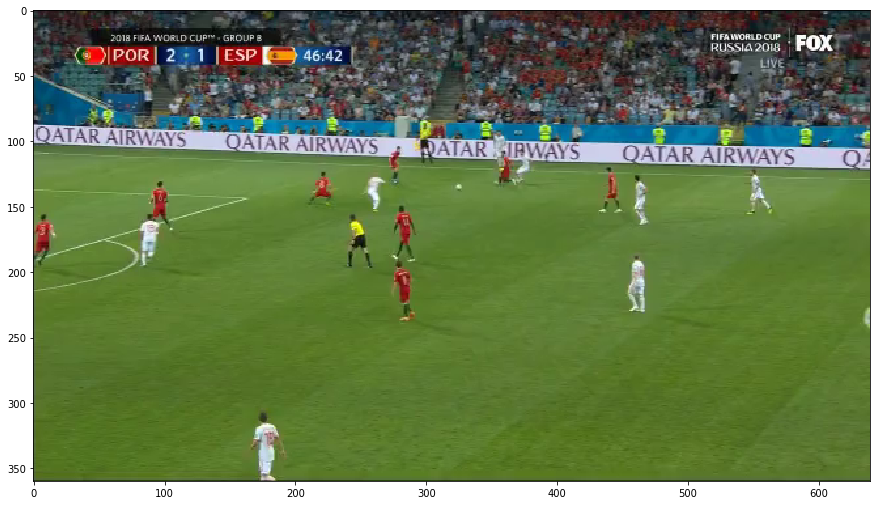

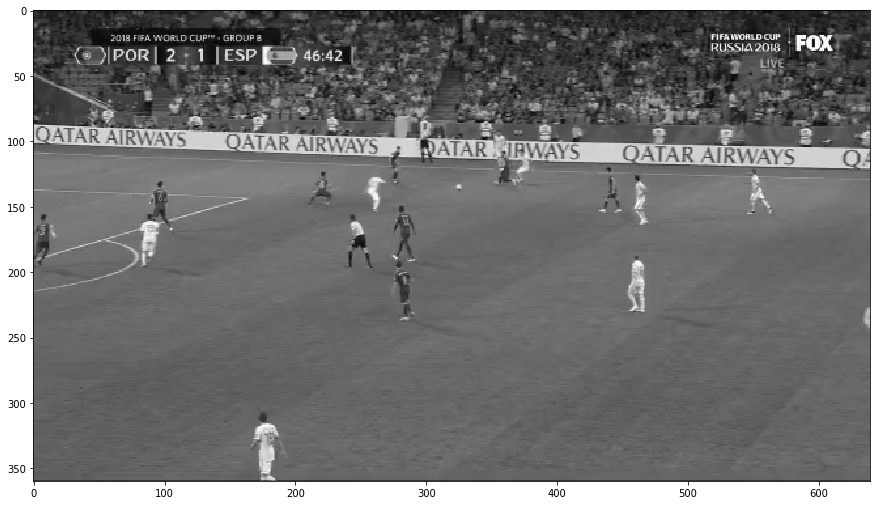

In [2]:
import cv2
import matplotlib.pyplot as plt
from time import sleep

def show_img(img, size=(15, 15)):
    plt.figure(figsize=size)
    
    if len(img.shape) == 2:
        plt.imshow(img)
    else:
        plt.gray()
        plt.imshow(img[:, :, ::-1])
    plt.show()

FPS = 35
WINDOW_NAME = 'Partida'
RUN_VIDEO = False
video_path = '../samples_offside/sample21.mp4'

vidcap = cv2.VideoCapture(video_path)
success,image = vidcap.read()

while success and RUN_VIDEO:
    cv2.imshow(WINDOW_NAME, image)
    
    # CODE
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    sleep(1/FPS)
    success,image = vidcap.read()

vidcap.release()
cv2.destroyAllWindows()

if success:
    show_img(image)

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    show_img(image_gray)
